In [1]:
# import packages
import cvxopt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.multivariate.pca import PCA

In [2]:
# adjust default plot fonts
plt.rc('font', size=11)
plt.rc('figure', titlesize=13)

In [3]:
# set paths
file_train = '~/Downloads/SpotX/house-prices-advanced-regression-techniques/train.csv'
file_test = '~/Downloads/SpotX/house-prices-advanced-regression-techniques/test.csv'
file_benchmark = '~/Downloads/SpotX/house-prices-advanced-regression-techniques/sample_submission.csv'

In [4]:
# create dataframes
df_train0 = pd.read_csv(file_train)
df_test0 = pd.read_csv(file_test)
df_benchmark = pd.read_csv(file_benchmark)

In [5]:
# convert false missing values back to 'NA'
col_index = df_train0.columns.to_list()
list_false_na = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
df_false_na = df_train0.loc[:, list_false_na].fillna(value='NA')
df_train1 = df_train0.drop(list_false_na, axis=1)
df_train2 = df_train1.join(df_false_na)
df_train3 = df_train2.reindex(columns=col_index)

In [6]:
# create SalePriceCategory
df_train4 = df_train3.assign(SalePriceCategory=np.where(df_train3['SalePrice']>=200000, 1, 0))

In [7]:
# delete rows with missing values
df_train5 = df_train4.dropna()

In [8]:
# descriptive statistics
print('Descriptive Statistics for Sale Price\n')
print('skewness      %f' % df_train5['SalePrice'].skew())
print('kurtosis      %f' % df_train5['SalePrice'].kurt())
print(df_train5.loc[:, 'SalePrice'].describe())

Descriptive Statistics for Sale Price

skewness      1.932304
kurtosis      6.424343
count      1120.000000
mean     185522.229464
std       83034.490782
min       35311.000000
25%      130875.000000
50%      164800.000000
75%      219500.000000
max      755000.000000
Name: SalePrice, dtype: float64


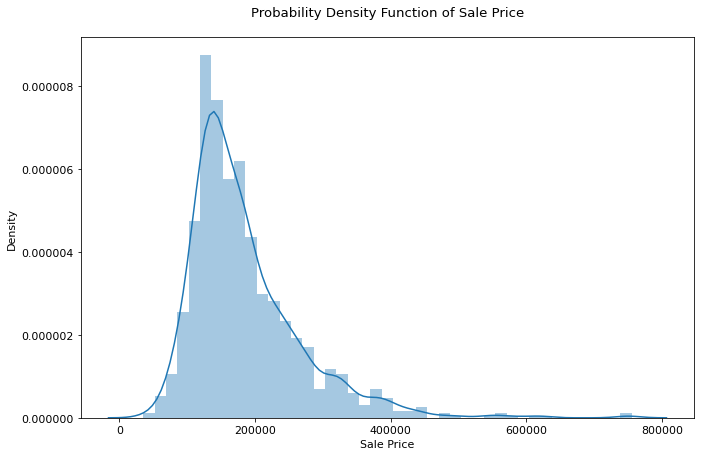

In [9]:
# histogram
f, ax = plt.subplots(figsize=(11, 7))
sns.distplot(df_train5['SalePrice'])
plt.ticklabel_format(style='plain', axis='y')
ax.set_title('Probability Density Function of Sale Price\n')
ax.set_xlabel('Sale Price')
ax.set_ylabel('Density')
plt.show()

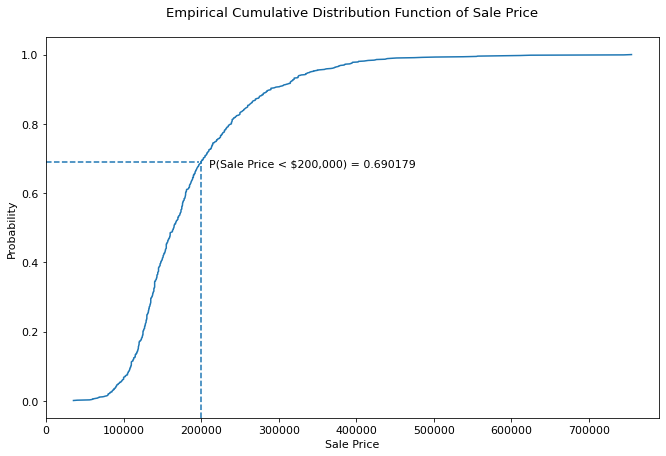

In [10]:
# empirical cumulative distribution function
f, ax = plt.subplots(figsize=(11, 7))
ecdf = ECDF(df_train5['SalePrice'])
threshold = ecdf(200000)
plt.plot(ecdf.x, ecdf.y)
ax.set_title('Empirical Cumulative Distribution Function of Sale Price\n')
ax.set_xlabel('Sale Price')
ax.set_ylabel('Probability')
plt.axhline(y=threshold, xmin=0, xmax=0.25, linestyle='--')
plt.axvline(x=200000, ymin=0, ymax=threshold-0.015, linestyle='--')
plt.text(x=210000, y=threshold-0.015, s='P(Sale Price < $200,000) = %f' % threshold)
plt.show()

In [11]:
# select variables with absolute correlation > 0.5
corr_minimum = abs(0.5)
corr_matrix0 = df_train5.corr(method='pearson')
corr_vars = corr_matrix0.gt(corr_minimum).query('SalePrice == True').index.to_list()
corr_vars.remove('SalePriceCategory')

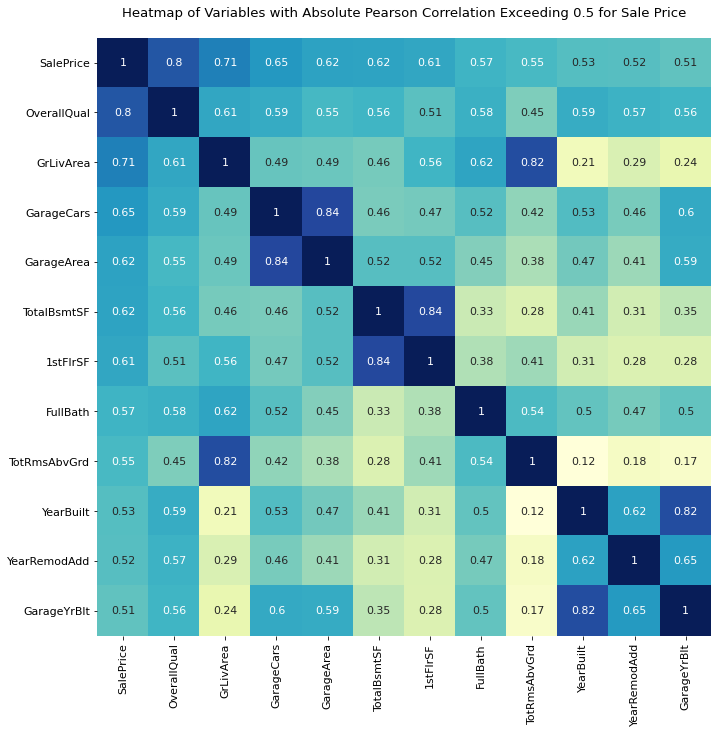

In [12]:
# correlation heatmap
corr_matrix1 = corr_matrix0.loc[corr_vars, corr_vars]
matrix_index = corr_matrix1.sort_values('SalePrice', ascending=False).index.to_list()
corr_matrix2 = corr_matrix1.reindex(index=matrix_index, columns=matrix_index)
f, ax = plt.subplots(figsize=(11, 11))
ax.set_title('Heatmap of Variables with Absolute Pearson Correlation Exceeding 0.5 for Sale Price\n')
sns.heatmap(corr_matrix2, cmap='YlGnBu', annot=True, cbar=False)
plt.show()

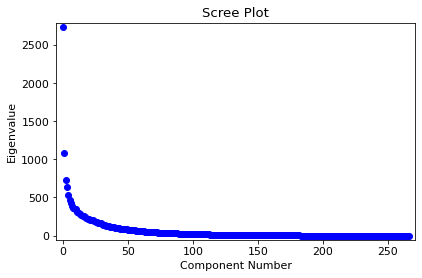

Top 15 Loadings for Principal Component 1 

                      comp_000
ExterQual_TA         0.258766
KitchenQual_TA       0.236530
BsmtQual_TA          0.235302
GarageFinish_Unf     0.234203
Foundation_CBlock    0.184807
GarageType_Detchd    0.172323
HeatingQC_TA         0.152478
MasVnrType_None      0.138321
LotShape_Reg         0.116454
FireplaceQu_NA       0.112844
BsmtExposure_No      0.094222
MSZoning_RM          0.083651
Neighborhood_NAmes   0.073620
SaleType_WD          0.071345
Exterior2nd_Wd Sdng  0.070787 

Top 15 Loadings for Principal Component 2 

                      comp_001
MSSubClass_20        0.312706
HouseStyle_1Story    0.292477
Foundation_CBlock    0.262005
GarageType_Attchd    0.258929
MSZoning_RL          0.236405
Neighborhood_NAmes   0.158572
MasVnrType_BrkFace   0.154258
RoofStyle_Hip        0.152568
Exterior1st_HdBoard  0.123209
Exterior2nd_HdBoard  0.107098
Alley_NA             0.100863
HeatingQC_TA         0.092984
GarageFinish_RFn     0.090889
BsmtFinT

In [13]:
# create principal components
# NOTE: drop_first=False for get_dummies because PCA eliminates collinearity
list_dummy_vars = ['MSSubClass'] + df_train5.select_dtypes(include=['object']).columns.to_list()
df_dummy_vars = pd.get_dummies(df_train5.loc[:, list_dummy_vars].astype('category'), prefix=list_dummy_vars, drop_first=False, dtype=int)
pca_model = PCA(df_dummy_vars, standardize=False)
df_train6 = df_train5.join(pca_model.factors)
pca_model.plot_scree(log_scale=False)
plt.show()
print('Top 15 Loadings for Principal Component 1', '\n\n', pca_model.loadings.loc[:, ['comp_000']].nlargest(15, ['comp_000']), '\n')
print('Top 15 Loadings for Principal Component 2', '\n\n', pca_model.loadings.loc[:, ['comp_001']].nlargest(15, ['comp_001']), '\n')
print('Top 15 Loadings for Principal Component 3', '\n\n', pca_model.loadings.loc[:, ['comp_002']].nlargest(15, ['comp_002']))

In [14]:
# logit model
predict_vars = corr_vars + ['comp_000', 'comp_001', 'comp_002']
predict_vars.remove('SalePrice')
y = df_train6.loc[:, 'SalePriceCategory']
X = sm.add_constant(df_train6.loc[:, predict_vars].astype('float'))
logit_model = sm.Logit(y, X)
logit_results = logit_model.fit_regularized(method='l1_cvxopt_cp', disp=0, alpha=0)
margeff = logit_results.get_margeff()
print(logit_results.summary(), '\n')
print(margeff.summary())

                           Logit Regression Results                           
Dep. Variable:      SalePriceCategory   No. Observations:                 1120
Model:                          Logit   Df Residuals:                     1105
Method:                           MLE   Df Model:                           14
Date:                Tue, 25 Aug 2020   Pseudo R-squ.:                  0.6638
Time:                        14:21:19   Log-Likelihood:                -234.37
converged:                       True   LL-Null:                       -697.19
Covariance Type:            nonrobust   LLR p-value:                1.394e-188
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -5.4540     32.388     -0.168      0.866     -68.934      58.026
OverallQual      0.8951      0.182      4.914      0.000       0.538       1.252
YearBuilt        0.0226      0.017      1.31

In [15]:
# train prediction
col1 = df_train6.loc[:, 'Id']
col2 = df_train6.loc[:, 'SalePrice']
col3 = df_train6.loc[:, 'SalePriceCategory']
col4 = logit_results.predict(X)
df_train_estimates = pd.concat([col1, col2, col3, col4], axis=1, keys=['Id', 'Sale Price', 'Sale Price Category', 'Predicted Probability'])
df_train_estimates['Predicted Category'] = np.where(df_train_estimates['Predicted Probability']>=threshold, 1, 0)
df_train_estimates['TP'] = np.where((df_train_estimates['Sale Price Category']==1) & (df_train_estimates['Predicted Category']==1), 1, 0)
df_train_estimates['TN'] = np.where((df_train_estimates['Sale Price Category']==0) & (df_train_estimates['Predicted Category']==0), 1, 0)
df_train_estimates['FP'] = np.where((df_train_estimates['Sale Price Category']==0) & (df_train_estimates['Predicted Category']==1), 1, 0)
df_train_estimates['FN'] = np.where((df_train_estimates['Sale Price Category']==1) & (df_train_estimates['Predicted Category']==0), 1, 0)

In [16]:
# train predictive fitness
TP = df_train_estimates.loc[:, 'TP'].sum()
TN = df_train_estimates.loc[:, 'TN'].sum()
FP = df_train_estimates.loc[:, 'FP'].sum()
FN = df_train_estimates.loc[:, 'FN'].sum()
ACC = (TP+TN)/(TP+TN+FP+FN)
PPV = TP/(TP+FP)
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
print('Train Predictive Fitness\n')
print('Accuracy:     %f' % ACC)
print('Precision:    %f' % PPV)
print('Sensitivity:  %f' % TPR)
print('Specificity:  %f' % TNR)

Train Predictive Fitness

Accuracy:     0.919643
Precision:    0.961268
Sensitivity:  0.775568
Specificity:  0.985677


In [17]:
# ready test data
df_test1 = df_test0.join(df_benchmark, lsuffix='_left', rsuffix='_right')
col_index = df_test1.columns.to_list()
list_false_na = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
df_false_na = df_test1.loc[:, list_false_na].fillna(value='NA')
df_test2 = df_test1.drop(list_false_na, axis=1)
df_test3 = df_test2.join(df_false_na)
df_test4 = df_test3.reindex(columns=col_index)
df_test5 = df_test4.assign(SalePriceCategory=np.where(df_test4['SalePrice']>=200000, 1, 0))
df_test6 = df_test5.dropna()
list_dummy_vars = ['MSSubClass'] + df_test6.select_dtypes(include=['object']).columns.to_list()
df_dummy_vars = pd.get_dummies(df_test6.loc[:, list_dummy_vars].astype('category'), prefix=list_dummy_vars, drop_first=False, dtype=int)
pca_model = PCA(df_dummy_vars, standardize=False)
df_test6 = df_test6.join(pca_model.factors)

In [18]:
# test prediction
X = sm.add_constant(df_test6.loc[:, predict_vars].astype('float'))
col1 = df_test6.loc[:, 'Id_left']
col2 = df_test6.loc[:, 'SalePrice']
col3 = df_test6.loc[:, 'SalePriceCategory']
col4 = logit_results.predict(X)
df_test_estimates = pd.concat([col1, col2, col3, col4], axis=1, keys=['Id', 'Sale Price', 'Sale Price Category', 'Predicted Probability'])
df_test_estimates['Predicted Category'] = np.where(df_test_estimates['Predicted Probability']>=threshold, 1, 0)
df_test_estimates['TP'] = np.where((df_test_estimates['Sale Price Category']==1) & (df_test_estimates['Predicted Category']==1), 1, 0)
df_test_estimates['TN'] = np.where((df_test_estimates['Sale Price Category']==0) & (df_test_estimates['Predicted Category']==0), 1, 0)
df_test_estimates['FP'] = np.where((df_test_estimates['Sale Price Category']==0) & (df_test_estimates['Predicted Category']==1), 1, 0)
df_test_estimates['FN'] = np.where((df_test_estimates['Sale Price Category']==1) & (df_test_estimates['Predicted Category']==0), 1, 0)

In [19]:
# test predictive fitness
TP = df_test_estimates.loc[:, 'TP'].sum()
TN = df_test_estimates.loc[:, 'TN'].sum()
FP = df_test_estimates.loc[:, 'FP'].sum()
FN = df_test_estimates.loc[:, 'FN'].sum()
ACC = (TP+TN)/(TP+TN+FP+FN)
PPV = TP/(TP+FP)
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
print('Test Predictive Fitness\n')
print('Accuracy:     %f' % ACC)
print('Precision:    %f' % PPV)
print('Sensitivity:  %f' % TPR)
print('Specificity:  %f' % TNR)

Test Predictive Fitness

Accuracy:     0.887621
Precision:    0.300000
Sensitivity:  0.583333
Specificity:  0.908154
